# Claim detection
The dataset(IBM Debator - Claim Stance Dataset) can be accessed [here](http://www.research.ibm.com/haifa/dept/vst/debating_data.shtml)

This dataset contains: 2,394 labeled claims for 55 topics. The dataset includes the stance (Pro/Con) of each claim towards the topic, as well as fine-grained annotations, based on the semantic model of Bar-Haim et al. [2017a] (topic target, topic sentiment towards its target, claim target, claim sentiment towards its target, and the relation 
between the targets).

The dataset includes: 
1. A utf-8 JSON file containing the topics and the claims found for these topics in Wikipedia articles. 
   Topics and claims are annotated as described above. 
2. A utf-8 CSV file containing the same information as the JSON file.
3. The original Wikipedia articles - from Wikipedia April 2012 dump - in the form of text files. 
   For each article, we provide both the original (raw) version, and a clean version, in which any Wikisyntax 
   and HTML markup is removed.
4. A CSV index file, containing the article title and Wikipedia URL for each article.   


In [2]:
import numpy as np
import pandas as pd
import string
import nltk
import gensim
import os
import warnings
import matplotlib.pyplot as plt
import scikitplot as skplt
import networkx as nx
 
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten,TimeDistributed,LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

%notebook inline
warnings.filterwarnings("ignore")
root = os.getcwd() + '/IBM_EACL-2017.v1/'

In [ ]:
# skplt.plot_confusion_matrix(y, preds)

# 1. Reading in data

### articles
num: 547

Note: There're 5013 texts within articles folder, so this dataframe only contains articles that are labeled as one of the 58 topics

In [3]:
def read_file(filename):
    data = []
    with open(filename, 'r') as f:
        text = f.read().split('\n')
        for parag in text:
            if len(parag) >2:
                data = data + [a for a in parag.split('. ') if len(a)>0]
                
    return data

In [4]:
articles = dict()
for subdir, dirs, files in os.walk(root+'articles/'):
    for file in files:
        if file[-3:] == 'txt' and file[:5] == 'clean':
            filename = os.path.join(subdir, file)
            articles[file] = read_file(filename)


### claims
num: 2394

In [5]:
claimDF = pd.read_csv("IBM_EACL-2017.v1/claim_stance_dataset_v1.csv")
article_paths = set(claimDF['claims.article.cleanFile'])

In [6]:
claimDF[:1].T

,0
topicId,1
split,test
topicText,This house believes that the sale of violent v...
topicTarget,the sale of violent video games to minors
topicSentiment,-1
claims.claimId,2973
claims.stance,PRO
claims.claimCorrectedText,Exposure to violent video games causes at leas...
claims.claimOriginalText,exposure to violent video games causes at leas...
claims.article.rawFile,articles/t1/raw_1.txt


In [ ]:
# I've just realized that one sentence could contain more than one claims, 
# so I'll just tag it as 1 as long as it contains one claim

In [7]:
def textrank(sentences):
#     sentence_tokenizer = PunktSentenceTokenizer()
#     sentences = sentence_tokenizer.tokenize(document)
 
    bow_matrix = CountVectorizer().fit_transform(sentences)
    normalized = TfidfTransformer().fit_transform(bow_matrix)
 
    similarity_graph = normalized * normalized.T
 
    nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
    scores = nx.pagerank(nx_graph)
    
    return dict((s, scores[i]) for i,s in enumerate(sentences))

In [8]:
articles_tags = []
articles_sent_length = []
sentences = []
topics = []
article_locs = []
article_rank = []

for a in article_paths:
    article_name = a.split('/')[-1]
    sents = articles[article_name]
    rank_dict = textrank(sents)
    claims = list(claimDF[claimDF['claims.article.cleanFile'] == a]['claims.claimOriginalText'])
    topic = list(claimDF[claimDF['claims.article.cleanFile'] == a]['topicTarget'])[0]
    tags = []
    sent_length = []
    locs = []
    rank = []

    for i, sent in enumerate(sents):
        # get normalized location
        locs.append(i+1/float(len(sents)))
        
        # get text rank score
        r = rank_dict[sent]
        rank.append(r)
        
        # get sent length
        tokens = [a for a in sent.split() if a != '']
        sent_length.append(len(tokens))
        
        topics.append(topic)
        flag = False
        for claim in claims:
            if claim in sent:
                tags.append(1)
                claims.remove(claim)
                flag = True
                break
        if not flag:
            tags.append(0)  
    
    sentences.append(sents)
    articles_tags.append(tags)
    article_locs.append(locs)
    articles_sent_length.append(sent_length)
    article_rank.append(rank)

In [12]:
d = {'sentences': sum(sentences, []), 
     'topic': topics, 
     'length': sum(articles_sent_length, []), 
     'label': sum(articles_tags, []),
    'loc': sum(article_locs, []),
    'rank': sum(article_rank, [])}
df = pd.DataFrame(d)

In [10]:
data = list(zip(sum(sentences, []), topics,\
           sum(articles_sent_length, []), sum(articles_tags, []), \
           sum(article_locs, []),sum(article_locs, [])))

# sentence, topic, length, label, loc, rank

# 2.  Feature Engineeing

- Mean embedding of the sentence
- similarity between sentence and topic (cosine similarity )
- length of the sentence
- index of the sentence in the article

## Train word embeddings with Word2Vec

In [15]:
def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         X = MyTokenizer().fit_transform(X)

        X = X.split(' ')
        emb = []
        for word in X:
            if word in self.word2vec.wv:
                emb.append(self.word2vec.wv[word])
            else:
                emb.append(np.zeros(self.dim))
        return np.mean(emb, axis = 0) #.reshape(1, 100)[0]
        
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [16]:
x = []
w2vec = get_word2vec(x, 'w2vmodel')     #note, model is trained in 2_data_cleaning_word2vec script

Found w2vmodel


In [17]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)

## Prepare data for training/testing

In [18]:
def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item

In [31]:
def prepare_data(tmp, mean_embedding_vectorizer = mean_embedding_vectorizer):
    tmp['embed_sent'] = tmp['sentences'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['embed_t']= tmp['topic'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['similarity'] = tmp.apply(lambda x: cosine_similarity(x['embed_t'].reshape(1, -1),\
                                                              x['embed_sent'].reshape(1, -1))[0][0],1)
    tmp_y = list(tmp['label'])
    y = np.zeros((len(tmp_y), 2))
    for i, a in enumerate(tmp_y):
        y[i][a] = 1
    
    
    col = ['embed_sent', 'similarity', 'loc', 'length','rank']
    X = tmp[col].apply(lambda x: list(flatten(x)),1)
    X = np.array(list(X))
    
    return (X, y)

### Wait, wait! Notice that the number of real claims are way way way less?
### Let's upsample that class first

In [20]:
from sklearn.utils import resample

In [32]:
# Separate majority and minority classes
df_majority = df[df.label==0]
df_minority = df[df.label==1]

In [42]:
len(df_majority)

88273

In [43]:
len(df_minority)

2223

In [33]:
NUMBER_PER_CLASS = 3500
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results

df_majority_downsampled = df_majority.sample(NUMBER_PER_CLASS)


# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])

In [34]:
train, test = train_test_split(df_upsampled, test_size=0.2)

In [36]:
train_X, train_y = prepare_data(train)
test_X, test_y = prepare_data(test)

In [37]:
train_X.shape

(5600, 104)

# 3. Models

## Model 1: Feedforward neural network

In [276]:
# path = os.getcwd()
# callbacks = [
#     EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
#     ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
#                                     save_best_only= True, save_weights_only=False, mode='max', period=1),]

In [26]:
def model_evaluation(model, test_X, test):
    res = model.predict(test_X)
    pred = res.argmax(1)
    y = list(test['label'])
    skplt.metrics.plot_confusion_matrix(y, pred)

In [38]:
def wrapper(name = 'm', w = 1, n_hidden = 1, layer_width = 128, activ_func = 'tanh', input_dim = 104):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
    
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
    
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 

    score = model.evaluate(test_X, test_y, verbose= 0)
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])

In [39]:
name = 'nn_default.h5'
m = wrapper(name)
# model = load_model('my_model.h5')

Accuracy on test: 0.667142857483


In [40]:
model_list = []
acc_list = []
for n_hidden in range(1,4):
    for i in [256,512, 1024]:
        for f in ['identity', 'tanh', 'relu', 'sigmoid']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            
            m, s = wrapper(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list.append(m)
            acc_list.append(s)
            print('-'*28)

Number of hidden layers: 1
Layer width: 256
Activation function: identity
Accuracy on test: 0.64500000017
----------------------------
Number of hidden layers: 1
Layer width: 256
Activation function: tanh
Accuracy on test: 0.677142857143
----------------------------
Number of hidden layers: 1
Layer width: 256
Activation function: relu
Accuracy on test: 0.571428571088
----------------------------
Number of hidden layers: 1
Layer width: 256
Activation function: sigmoid
Accuracy on test: 0.645714285714
----------------------------
Number of hidden layers: 1
Layer width: 512
Activation function: identity
Accuracy on test: 0.660714285714
----------------------------
Number of hidden layers: 1
Layer width: 512
Activation function: tanh
Accuracy on test: 0.680714286055
----------------------------
Number of hidden layers: 1
Layer width: 512
Activation function: relu
Accuracy on test: 0.597857142857
----------------------------
Number of hidden layers: 1
Layer width: 512
Activation function: s

Accuracy on test: 0.715000000341


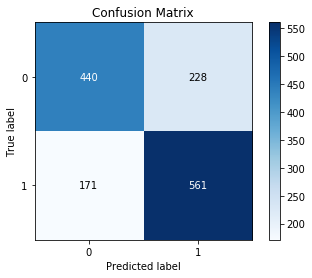

In [41]:
best_model = model_list[acc_list.index(max(acc_list))]
score = best_model.evaluate(test_X, test_y, verbose= 0)
print('Accuracy on test:', score[1])
model_evaluation(best_model, test_X, test)

In [ ]:
score[0]

## Model 2: LSTM

In [45]:
train_X_ = np.expand_dims(train_X, axis=1)
test_X_ = np.expand_dims(test_X, axis=1)

In [44]:
def wrapper_lstm(name = 'm', w = 1, n_hidden = 1, layer_width = 128, activ_func = 'tanh', input_dim = 104):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
        
    model.add(LSTM(layer_width, input_dim=input_dim))
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
        
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X_, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 

    score = model.evaluate(test_X_, test_y, verbose= 0)
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])

In [ ]:
model_list = []
acc_list = []
for n_hidden in range(1,3):
    for i in [128,256,512, 1024]:
        for f in ['identity', 'tanh', 'relu', 'sigmoid']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            
            m, s = wrapper_lstm(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list.append(m)
            acc_list.append(s)
            print('-'*28)

In [57]:
lstm_model = model_list[acc_list.index(max(acc_list))]

Accuracy on test: 0.715


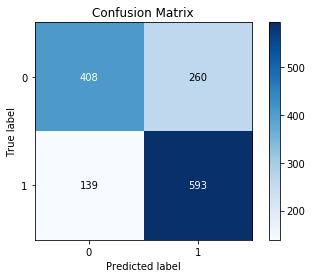

In [58]:
lstm_score = lstm_model.evaluate(test_X_, test_y, verbose= 0)
print('Accuracy on test:', lstm_score[1])
model_evaluation(lstm_model, test_X_, test)

In [60]:
lstm_score

[0.57730430330548965, 0.71499999999999997]